In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import time
from PIL import Image
import pytesseract
import easyocr
from ArabicOcr import arabicocr
import numpy as np
import os
import glob 
import json
import shutil

C:\Users\Elsou\anaconda3\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_text(img_crop, factor = [0.8,0.8,0.9], word=True, number="number", config="--psm 8"):
    text = ""
    ID_text = ""
    text_ = ""
    
    lower = (0, 0, 0)
    factor = [0.8,0.8,0.9]
    upper =(int(np.average(img_crop[:,:,0])*factor[0]),int(np.average(img_crop[:,:,1])*factor[1]),int(np.average(img_crop[:,:,2])*factor[2]))

    img_rgb_inrange = cv2.inRange(img_crop, lower, upper)
    neg_rgb_image = ~img_rgb_inrange
    #neg_rgb_image = cv2.threshold(neg_rgb_image, int(np.average(neg_rgb_image)*0.5),255, cv2.THRESH_BINARY)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    opening = cv2.morphologyEx(neg_rgb_image, cv2.MORPH_OPEN, kernel, iterations=1)
    thresh = cv2.GaussianBlur(neg_rgb_image,(3,3),4)


    results = reader.readtext(thresh)

    for t in results:
        text_ +=t[1] +" "
    
    
    if word==True:
        text=""
        text = pytesseract.image_to_string(thresh, lang="ara", config=config)

     
    elif number=="number":
            ID_text = pytesseract.image_to_string(thresh,lang='arab_numbers', config=config)
            text = pytesseract.image_to_string(thresh,lang='ara_number')
            
       
    elif number=="date":
            text = pytesseract.image_to_string(thresh,lang='arab_numbers', config=config)
            
            
    elif word==False:
        text = pytesseract.image_to_string(thresh,lang='ara', config="--psm 7")
        
    elif word=="False":
        text = pytesseract.image_to_string(thresh,lang='ara')
        
    return text, text_,thresh  


def birth_text(text):
    text_birth  = ""
    if text[0:1]==2:
        text_birth = f"19{text[1:3]}/{text[3:5]}/{text[5:7]}"
        
    elif text[0:1]==3:
        text_birth = f"20{text[1:3]}/{text[3:5]}/{text[5:7]}"
    return text_birth

In [3]:
model = YOLO('model/bestX_withoutCard.pt')

model_card = YOLO('model/card_x_2best.pt')

reader = easyocr.Reader(["ar"])

path_list = glob.glob("img/*.jpg")
n = 0


C:\Users\Elsou\anaconda3\envs\env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
0: 640x640 1 Card, 55.9ms
Speed: 15.5ms preprocess, 55.9ms inference, 17.9ms postprocess per image at shape (1, 3, 640, 640)


1326 2194 3



0: 640x640 2 Add1s, 1 Add2, 1 Birth, 1 FN, 1 Face, 1 Id, 2 LNs, 54.1ms
Speed: 2.5ms preprocess, 54.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


pytesseract == {'Frist Name= ': 'يونان', 'Last Name= ': 'ناجى يونان مسعود', 'Add1= ': '//ش عبدالبصير محمد عزبة مرسى خليل', 'Add2= ': 'الزيتون - القاهره', 'Id': '', 'Birth= ': '', 'Gender= ': '', 'Job= ': '', 'Job2= ': '', 'Marital_status= ': '', 'Partner= ': '', 'Religion= ': '', 'Id= ': '29607220103613', 'Face= ': '4 ١'}
time ==  5.465936183929443 n== 0


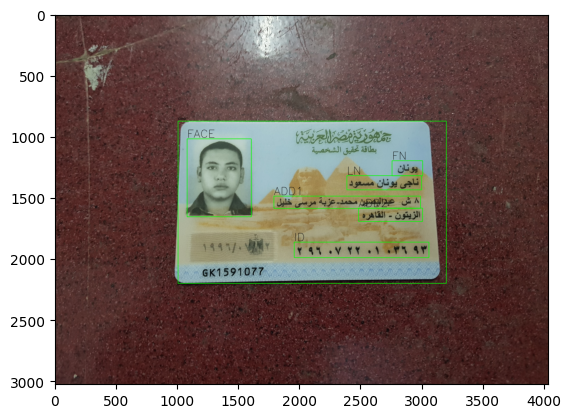

In [4]:
org = cv2.imread(path_list[n])#path_list[7]
h_,w_,_ = org.shape
org = cv2.cvtColor(org, cv2.COLOR_BGR2RGB)
draw_img = org.copy()
img = cv2.resize(org, (640,640))


s = time.time()
out_card = model_card(img)[0]
dect_name = {'Frist Name= ': "", 'Last Name= ': "", 'Add1= ': "", 'Add2= ': "", 'Id': "", 'Birth= ':" ",
'Gender= ': "",'Job= ': "", 'Job2= ': "", 'Marital_status= ': "", 'Partner= ': "", 'Religion= ': ""}

dect_ocr = {'Frist Name= ': "", 'Last Name= ': "", 'Add1= ': "", 'Add2= ': "", 'Id': "", 'Birth= ':" ",
'Gender= ': "",'Job= ': "", 'Job2= ': "", 'Marital_status= ': "", 'Partner= ': "", 'Religion= ': ""}
for axis ,out in enumerate(out_card.boxes.data.tolist()):
    x1_, y1_, x2_, y2_, score, class_id = out
    name_card = out_card.names[int(class_id)]
    if score < 0.5:
        continue
    

    x1_, y1_, x2_, y2_ = int((x1_/640) * w_), int((y1_/640) * h_), int((x2_/640) * w_), int((y2_/640) * h_)
    img_card = org[int(y1_):int(y2_),int(x1_):int(x2_)]

    h,w,_ = img_card.shape
    print(h,w,_)


    img_card = cv2.resize(img_card, (640,640))
    cv2.rectangle(draw_img, (int(x1_), int(y1_)), (int(x2_), int(y2_)), (0, 255, 0), 4)
    cv2.putText(draw_img, out_card.names[int(class_id)].upper(), (int(x1_), int(y1_ - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    
    outs = model(img_card)[0]
    date = False


    for axis ,out in enumerate(outs.boxes.data.tolist()):
        x1, y1, x2, y2, score, class_id = out
        x1, y1, x2, y2 = int(((x1/640) * w)+x1_), int(((y1/640) * h)+y1_), int(((x2/640) * w)+x1_), int(((y2/640) * h)+y1_)
        name_class = outs.names[int(class_id)]
        img_crop = org[int(y1):int(y2),int(x1):int(x2)]
        
        

        if score > 0.5:




            if name_class == "FN" :
                text,text_ocr, thresh = extract_text(img_crop, factor = [0.8,0.8,0.9], word=True, number="n", config="--psm 7")
                dect_name["Frist Name= "] = text.replace("\n" , "")
                dect_ocr["Frist Name= "] = text_ocr.replace("\n" , "")
                thresh_f = thresh
                text_ = reader.readtext(thresh)

 
            elif name_class == "LN":
                text,text_ocr, thresh = extract_text(img_crop, factor = [0.8,0.8,0.9], word=True, number="n", config="--psm 8")#img_crop, word="False", factor=0.60,number="n"
                thresh_f = thresh
                dect_name["Last Name= "] = text.replace("\n" , "")
                dect_ocr["Last Name= "] = text_ocr.replace("\n" , "")                
                
                
            
            
            
            elif name_class == "Job":
                text,text_ocr, thresh = extract_text(img_crop, factor = [0.8,0.8,0.9], word=True, number="n", config="--psm 6")
                dect_name["Job= "] = text.replace("\n" , "")
                text_ = reader.readtext(thresh)


            elif name_class == "Gender" or name_class == "Marital_status" or name_class == "Religion":

                text,text_ocr, thresh = extract_text(img_crop, factor = [0.8,0.8,0.9], word=True, number="n", config="--psm 6")
                dect_name[f"{name_class}= "] = text.replace("\n" , "")
                dect_ocr[f"{name_class}= "] = text_ocr.replace("\n" , "")               

                
                
                
                
            elif name_class == "Add1":
                text,text_ocr, thresh = extract_text(img_crop, word=True, factor = [0.8,0.8,0.9],number="n", config='--psm 8')
                dect_name["Add1= "] = text.replace("\n" , "")
                dect_ocr["Add1= "] = text_ocr.replace("\n" , "")

            elif name_class == "Add2":
                text,text_ocr, thresh = extract_text(img_crop, factor = [0.8,0.8,0.9], word=True, number="n", config="--psm 7")
                dect_name["Add2= "] = text.replace("\n" , "")
                dect_ocr["Add2= "] = text_ocr.replace("\n" , "")

  


            elif name_class == "Id":
                text,text_ocr, thresh = extract_text(img_crop, factor = [0.7,0.7,0.7], word=None, number="number", config="--psm 8")
                text = text.replace(" " , "").replace("\n" , "")
                dect_name["Id= "] = text.replace(" " , "").replace("\n" , "")
                dect_ocr["Id= "] = text_ocr.replace("\n" , "")
                text_birth = ""
                if text[0:1]=="2":
                    text_birth = f"19{text[1:3]}/{text[3:5]}/{text[5:7]}"

                elif text[0:1]=="3":
                     text_birth = f"20{text[1:3]}/{text[3:5]}/{text[5:7]}"
                text_birth = birth_text(text)
                dect_name["Birth= "] = text_birth
            
            elif name_class == "Birth" :
                continue
                
                
                
                
                
                
            elif name_class == "Ex_y" or name_class == "Ex_d" or name_class == "Ex_m":
                text,text_ocr, thresh = extract_text(img_crop, factor = [0.8,0.8,0.9], word=None, number="date", config="--psm 8")
                date = "True"    
                globals()[name_class] = text.replace(" " , "").replace("\n" , "")

                

            else:
                text,text_ocr, thresh = extract_text(img_crop, factor = [0.8,0.8,0.9], word=False, number="n", config="--psm 10")
                dect_name[f"{name_class}= "] = text.replace("\n" , "")
                dect_ocr[f"{name_class}= "] = text_ocr.replace("\n" , "")


        

            cv2.rectangle(draw_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
            cv2.putText(draw_img, outs.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 2)
            


    print("pytesseract ==", dect_name)

                

e = time.time()
print("time == ",e-s, "n==", n)
n+=1
plt.imshow(draw_img, cmap="gray")